In [1]:
import shap
import joblib
import numpy as np
import pandas as pd
import pickle
#import pyarrow as pa
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import logging
#import matplotlib

/home/jarts/.conda/envs/shap040/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip list

Package            Version
------------------ --------
asttokens          2.4.1
certifi            2024.7.4
cloudpickle        3.0.0
colorama           0.4.6
comm               0.2.2
contourpy          1.2.1
cycler             0.12.1
debugpy            1.8.1
decorator          5.1.1
exceptiongroup     1.2.0
executing          2.0.1
fonttools          4.51.0
importlib_metadata 7.1.0
ipykernel          6.29.3
ipython            8.22.2
jedi               0.19.1
joblib             1.4.0
jupyter_client     8.6.1
jupyter_core       5.7.2
kiwisolver         1.4.5
llvmlite           0.42.0
matplotlib         3.8.4
matplotlib-inline  0.1.6
munkres            1.1.4
nest_asyncio       1.6.0
numba              0.59.1
numpy              1.23.5
packaging          24.0
pandas             2.2.1
parso              0.8.4
pexpect            4.9.0
pickleshare        0.7.5
pillow             10.3.0
pip                24.0
platformdirs       4.2.0
ply                3.11
prompt-toolkit     3.0.42
psutil    

In [3]:
class CpredictorClassifier():
    def __init__(self, Threshold_rej, rejected, OutputDir):
        self.scaler = MinMaxScaler()
        self.Classifier = LinearSVC(dual = False, random_state = 42, class_weight = 'balanced', max_iter = 2500)
        self.threshold = Threshold_rej
        self.rejected = rejected
        self.output_dir = OutputDir
        self.expression_treshold = 162

    def expression_cutoff(self, Data, LabelsPath):
        logging.info(f'Selecting genes based on an summed expression threshold of minimally {self.expression_treshold} in each cluster')
        labels = pd.read_csv(LabelsPath,index_col=False)
        h5ad_object = Data.copy()
        cluster_id = 'labels'
        h5ad_object.obs[cluster_id] = labels.iloc[:, 0].tolist()
        res = pd.DataFrame(columns=h5ad_object.var_names.tolist(), index=h5ad_object.obs[cluster_id].astype("category").unique())
        
        ## Set up scanpy object based on expression treshold
        for clust in h5ad_object.obs[cluster_id].astype("category").unique():
            if h5ad_object.raw is not None:
                res.loc[clust] = h5ad_object[h5ad_object.obs[cluster_id].isin([clust]),:].raw.X.sum(0)
            else:
                res.loc[clust] = h5ad_object[h5ad_object.obs[cluster_id].isin([clust]),:].X.sum(0)
        res.loc["sum"]=np.sum(res,axis=0).tolist()
        res=res.transpose()
        res=res.loc[res['sum'] > self.expression_treshold]
        genes_expressed = res.index.tolist()
        logging.info("Amount of genes that remain: " + str(len(genes_expressed)))
        h5ad_object = h5ad_object[:, genes_expressed]
        Data = h5ad_object
        del res, h5ad_object

        return Data
        
    def preprocess_data_train(self, data_train):
        logging.info('Log normalizing the training data')
        np.log1p(data_train, out=data_train)
        logging.info('Scaling the training data')
        data_train = self.scaler.fit_transform(data_train)
        return data_train

    def preprocess_data_test(self, data_test):
        logging.info('Log normalizing the testing data')
        np.log1p(data_test, out=data_test)
        logging.info('Scaling the testing data')
        data_test = self.scaler.fit_transform(data_test)
        return data_test

    def fit_and_predict_svmrejection(self, labels_train, threshold, output_dir, data_train, data_test):
        self.rejected = True
        self.threshold = threshold
        self.output_dir = output_dir
        logging.info('Running SVMrejection')
        kf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
        clf = CalibratedClassifierCV(self.Classifier, cv=kf)
        clf.fit(data_train, labels_train.ravel())
        predicted = clf.predict(data_test)
        prob = np.max(clf.predict_proba(data_test), axis = 1)
        unlabeled = np.where(prob < self.threshold)

        # For unlabeled values from the SVMrejection put values of strings and integers
        try:
            predicted[unlabeled] = 'Unlabeled'
        except ValueError:
            unlabeled = list(unlabeled[0])
            predicted[unlabeled] = 999999
        self.predictions = predicted
        self.probabilities = prob
        self.save_results(self.rejected)

    def fit_and_predict_svm(self, labels_train, output_dir, data_train, data_test):
        self.rejected = False
        self.output_dir = output_dir
        logging.info('Running SVM')
        self.Classifier.fit(data_train, labels_train.ravel())
        self.predictions = self.Classifier.predict(data_test)
        self.save_results(self.rejected)

    def save_results(self, rejected):
        self.rejected = rejected
        self.predictions = pd.DataFrame(self.predictions)
        if self.rejected is True:
            self.probabilities = pd.DataFrame(self.probabilities)
            self.predictions.to_csv(f"{self.output_dir}/SVMrej_Pred_Labels.csv", index=False)
            self.probabilities.to_csv(f"{self.output_dir}/SVMrej_Prob.csv", index=False)
        else:
            self.predictions.to_csv(f"{self.output_dir}/SVM_Pred_Labels.csv", index=False)

# Child class for performance from the CpredictorClassifier class        
class CpredictorClassifierPerformance(CpredictorClassifier):
    def __init__(self, Threshold_rej, rejected, OutputDir):
        super().__init__(Threshold_rej, rejected, OutputDir)

    def fit_and_predict_svmrejection(self, labels_train, threshold, output_dir, data_train, data_test):
        # Calls the function from parent class and extends it for the child
        super().fit_and_predict_svmrejection(labels_train, threshold, output_dir, data_train, data_test)
        return self.predictions, self.probabilities

    def fit_and_predict_svm(self, labels_train, OutputDir, data_train, data_test):
        # Calls the function from parent class and extends it for the child
        super().fit_and_predict_svm(labels_train, OutputDir, data_train, data_test)
        return self.predictions

In [4]:
# Get the X-test (used the test as training for illustrative purposes):
import pyarrow as pa
with pa.memory_map('/mnt/c/Users/jarts/Documents/cpred_model/adultmaiti/data_test.arrow', 'rb') as source:
    data_test = pa.ipc.open_file(source).read_all()
    data_test = data_test.to_pandas().to_numpy()
data_test

array([[ 0.,  0.,  0., ...,  2.,  0.,  2.],
       [ 0.,  0.,  0., ...,  1.,  0., 10.],
       [ 0.,  0.,  0., ...,  0.,  0.,  4.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]], dtype=float16)

In [5]:
data_test.shape

(90931, 1242)

In [6]:
with open ('/mnt/c/Users/jarts/Documents/cpred_model/adultmaiti/mergedgenes', 'rb') as fp:
    features = pickle.load(fp)
features

['HES4',
 'MXRA8',
 'RER1',
 'HES5',
 'KCNAB2',
 'RPL22',
 'ENO1',
 'ANGPTL7',
 'TNFRSF1B',
 'PDPN',
 'EPHA2',
 'NBL1',
 'CAMK2N1',
 'HSPG2',
 'C1QA',
 'C1QB',
 'ID3',
 'CLIC4',
 'RUNX3',
 'STMN1',
 'AL391650.1',
 'SH3BGRL3',
 'SFN',
 'NUDC',
 'WASF2',
 'IFI6',
 'ATP5IF1',
 'LAPTM5',
 'SERINC2',
 'TINAGL1',
 'MARCKSL1',
 'GJB4',
 'GJB3',
 'COL8A2',
 'SMAP2',
 'YBX1',
 'SLC2A1',
 'RPS8',
 'PRDX1',
 'TSPAN1',
 'POMGNT1',
 'PLPP3',
 'TACSTD2',
 'JUN',
 'JAK1',
 'PDE4B',
 'GADD45A',
 'ADGRL4',
 'MCOLN3',
 'CLCA2',
 'LMO4',
 'TGFBR3',
 'RPL5',
 'GCLM',
 'ARHGAP29',
 'F3',
 'CNN3',
 'PALMD',
 'AGL',
 'S1PR1',
 'GSTM3',
 'AHCYL1',
 'CD53',
 'OLFML3',
 'DENND2C',
 'ATP1A1',
 'RBM8A',
 'TXNIP',
 'ECM1',
 'MCL1',
 'CTSS',
 'S100A10',
 'S100A11',
 'S100A9',
 'S100A8',
 'S100A6',
 'S100A4',
 'S100A2',
 'S100A16',
 'S100A14',
 'RPS27',
 'PBXIP1',
 'SHC1',
 'MUC1',
 'SSR2',
 'RAB25',
 'LMNA',
 'BCAN',
 'CRABP2',
 'IFI16',
 'ACKR1',
 'DUSP23',
 'CD48',
 'TSTD1',
 'NECTIN4',
 'FCER1G',
 'MPZ',
 'FCGR2

In [7]:
Threshold_rej = 0.7
rejected = True
OutputDir = "data2/"
cpredictor = CpredictorClassifier(Threshold_rej, rejected, OutputDir)

In [8]:
data_test = cpredictor.preprocess_data_test(data_test)

In [9]:
data_test.shape

(90931, 1242)

In [10]:
data_test

array([[0.    , 0.    , 0.    , ..., 0.3608, 0.    , 0.2479],
       [0.    , 0.    , 0.    , ..., 0.2277, 0.    , 0.5415],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.3633],
       ...,
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.1565],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.1565],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.1565]],
      dtype=float16)

In [11]:
data_test = pd.DataFrame(data_test, columns=features)
data_test

,HES4,MXRA8,RER1,HES5,KCNAB2,RPL22,ENO1,ANGPTL7,TNFRSF1B,PDPN,...,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
0,0.00000,0.0,0.000000,0.0,0.0,0.309082,0.158203,0.000000,0.0,0.00000,...,0.377930,0.5,0.340088,0.445312,0.306641,0.00000,0.000000,0.360840,0.000000,0.247925
1,0.00000,0.0,0.000000,0.0,0.0,0.195068,0.250732,0.000000,0.0,0.00000,...,0.404053,0.5,0.394775,0.475830,0.306641,0.00000,0.377686,0.227661,0.000000,0.541504
2,0.00000,0.0,0.000000,0.0,0.0,0.195068,0.474609,0.647461,0.0,0.00000,...,0.447266,0.0,0.394775,0.317139,0.306641,0.31543,0.325439,0.000000,0.000000,0.363281
3,0.00000,0.0,0.000000,0.0,0.0,0.309082,0.250732,0.336914,0.0,0.00000,...,0.512695,0.0,0.170044,0.368164,0.306641,0.00000,0.456543,0.227661,0.430908,0.363281
4,0.00000,0.0,0.387695,0.0,0.0,0.503906,0.646484,0.000000,0.0,0.39624,...,0.404053,0.0,0.170044,0.317139,0.000000,0.00000,0.377686,0.227661,0.000000,0.495850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90926,0.39624,0.0,0.000000,0.0,0.0,0.195068,0.525391,0.000000,0.0,0.00000,...,0.591309,0.0,0.269531,0.251221,0.386963,0.00000,0.257812,0.360840,0.000000,0.541504
90927,0.00000,0.0,0.000000,0.0,0.0,0.195068,0.000000,0.375244,0.0,0.25000,...,0.348145,0.0,0.394775,0.158569,0.193481,0.00000,0.000000,0.360840,0.000000,0.247925
90928,0.00000,0.0,0.000000,0.0,0.0,0.309082,0.250732,0.229980,0.0,0.39624,...,0.213379,0.0,0.000000,0.000000,0.000000,0.00000,0.162720,0.000000,0.000000,0.156494
90929,0.00000,0.0,0.000000,0.0,0.0,0.309082,0.501465,0.593262,0.0,0.25000,...,0.348145,0.0,0.170044,0.317139,0.000000,0.00000,0.000000,0.000000,0.000000,0.156494


In [12]:
labels= pd.read_csv('/mnt/c/Users/jarts/Documents/cpred_model/adultmaiti/SVM_Pred_Labels.csv',index_col=False)
labels

,0
0,LE
1,Cj
2,qSK
3,qSK
4,LSC-2
...,...
90926,LE
90927,SK
90928,SK
90929,SK


In [13]:
prob= pd.read_csv('/mnt/c/Users/jarts/Documents/cpred_model/adultmaiti/SVMrej_Prob.csv',index_col=False)
prob

,0
0,0.619381
1,0.646352
2,0.986777
3,0.959584
4,0.876334
...,...
90926,0.472503
90927,0.770364
90928,0.690036
90929,0.473414


# Adult maiti corneal cells

In [22]:
type = "adultmaiti"
np.random.seed(42)
data_test2 = data_test
data_test2['labels'] = labels
data_test2['prob'] = prob

# select random 15 samples with seed 42 out of the testing dataset (25 cells is too intensive)
data_test2 = data_test2.groupby('labels',as_index = False,group_keys=False).apply(lambda s: s.sample(15,replace=True))
data_test2 = data_test2.drop_duplicates()
data_test2

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,HES4,MXRA8,RER1,HES5,KCNAB2,RPL22,ENO1,ANGPTL7,TNFRSF1B,PDPN,...,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,labels,prob
90918,0.00,0.000000,0.000000,0.387695,0.0,0.452637,0.367188,0.000000,0.0,0.00000,...,0.269531,0.502441,0.000000,0.00000,0.162720,0.227661,0.0,0.404541,CE,0.980131
19331,0.00,0.000000,0.244629,0.000000,0.0,0.309082,0.316406,0.000000,0.0,0.00000,...,0.340088,0.368164,0.386963,0.00000,0.257812,0.000000,0.0,0.469482,CE,0.818356
80615,0.00,0.000000,0.000000,0.000000,0.0,0.195068,0.408936,0.407471,0.0,0.00000,...,0.340088,0.317139,0.000000,0.00000,0.456543,0.000000,0.0,0.495850,CE,0.933383
79713,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.408936,0.000000,0.0,0.25000,...,0.564941,0.603516,0.193481,0.31543,0.488037,0.360840,0.0,0.541504,CE,0.339653
79512,0.00,0.000000,0.000000,0.387695,0.0,0.309082,0.501465,0.000000,0.0,0.00000,...,0.170044,0.251221,0.193481,0.31543,0.162720,0.000000,0.0,0.404541,CE,0.984843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42647,0.00,0.613281,0.244629,0.000000,0.0,0.000000,0.367188,0.697754,0.0,0.00000,...,0.269531,0.158569,0.193481,0.00000,0.420410,0.000000,0.0,0.156494,qSK,0.968773
42353,0.00,0.386963,0.387695,0.000000,0.0,0.000000,0.367188,0.711914,0.0,0.25000,...,0.170044,0.158569,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,qSK,0.686605
4378,0.25,0.000000,0.244629,0.000000,0.0,0.195068,0.250732,0.501953,0.0,0.00000,...,0.170044,0.317139,0.000000,0.00000,0.420410,0.000000,0.0,0.156494,qSK,0.875312
38480,0.00,0.000000,0.000000,0.000000,0.0,0.503906,0.367188,0.616699,0.0,0.00000,...,0.170044,0.000000,0.000000,0.00000,0.377686,0.000000,0.0,0.000000,qSK,0.804066


In [23]:
balanced_df = data_test2
balanced_df['labels']=balanced_df['labels'].astype('category')
balanced_df['labels']=balanced_df['labels'].cat.reorder_categories(['LSC-1','LSC-2','LE','CE','Cj','qSK','SK','TSK','CF','IC','Ves','Mel','EC','nm-cSC','MC'])

In [24]:
balanced_df.sort_values(by=['labels'], inplace=True)

In [25]:
balanced_df

,HES4,MXRA8,RER1,HES5,KCNAB2,RPL22,ENO1,ANGPTL7,TNFRSF1B,PDPN,...,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,labels,prob
43616,0.000000,0.0,0.244629,0.000000,0.0,0.390137,0.000000,0.0,0.0,0.0,...,0.170044,0.409912,0.193481,0.00000,0.162720,0.227661,0.000000,0.363281,LSC-1,0.949337
11758,0.000000,0.0,0.000000,0.000000,0.0,0.390137,0.250732,0.0,0.0,0.0,...,0.539062,0.548828,0.193481,0.00000,0.162720,0.000000,0.000000,0.404541,LSC-1,0.801721
8622,0.000000,0.0,0.244629,0.000000,0.0,0.547363,0.444092,0.0,0.0,0.0,...,0.394775,0.445312,0.193481,0.00000,0.377686,0.000000,0.000000,0.312988,LSC-1,0.905271
23985,0.000000,0.0,0.244629,0.000000,0.0,0.452637,0.158203,0.0,0.0,0.0,...,0.269531,0.368164,0.193481,0.31543,0.377686,0.000000,0.430908,0.519531,LSC-1,0.899141
8258,0.250000,0.0,0.387695,0.000000,0.0,0.584961,0.000000,0.0,0.0,0.0,...,0.439453,0.475830,0.000000,0.00000,0.325439,0.227661,0.000000,0.519531,LSC-1,0.874134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19322,0.250000,0.0,0.244629,0.489258,0.0,0.000000,0.250732,0.0,0.0,0.0,...,0.477295,0.409912,0.386963,0.00000,0.583008,0.000000,0.000000,0.495850,MC,0.894459
4482,0.396240,0.0,0.000000,0.000000,0.0,0.309082,0.316406,0.0,0.0,0.0,...,0.340088,0.526855,0.449219,0.31543,0.377686,0.000000,0.000000,0.560547,MC,0.481656
6036,0.580566,0.0,0.000000,0.000000,0.0,0.309082,0.250732,0.0,0.0,0.0,...,0.609375,0.409912,0.500000,0.31543,0.257812,0.528320,0.000000,0.404541,MC,0.499938
4835,0.500000,0.0,0.244629,0.000000,0.0,0.000000,0.158203,0.0,0.0,0.0,...,0.394775,0.526855,0.386963,0.00000,0.488037,0.360840,0.000000,0.247925,MC,0.988590


In [26]:
data_test3 = balanced_df.drop(['labels', 'prob'], axis=1)
data_test3

,HES4,MXRA8,RER1,HES5,KCNAB2,RPL22,ENO1,ANGPTL7,TNFRSF1B,PDPN,...,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
43616,0.000000,0.0,0.244629,0.000000,0.0,0.390137,0.000000,0.0,0.0,0.0,...,0.213379,0.0,0.170044,0.409912,0.193481,0.00000,0.162720,0.227661,0.000000,0.363281
11758,0.000000,0.0,0.000000,0.000000,0.0,0.390137,0.250732,0.0,0.0,0.0,...,0.525879,0.0,0.539062,0.548828,0.193481,0.00000,0.162720,0.000000,0.000000,0.404541
8622,0.000000,0.0,0.244629,0.000000,0.0,0.547363,0.444092,0.0,0.0,0.0,...,0.404053,0.0,0.394775,0.445312,0.193481,0.00000,0.377686,0.000000,0.000000,0.312988
23985,0.000000,0.0,0.244629,0.000000,0.0,0.452637,0.158203,0.0,0.0,0.0,...,0.404053,0.0,0.269531,0.368164,0.193481,0.31543,0.377686,0.000000,0.430908,0.519531
8258,0.250000,0.0,0.387695,0.000000,0.0,0.584961,0.000000,0.0,0.0,0.0,...,0.447266,0.0,0.439453,0.475830,0.000000,0.00000,0.325439,0.227661,0.000000,0.519531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19322,0.250000,0.0,0.244629,0.489258,0.0,0.000000,0.250732,0.0,0.0,0.0,...,0.377930,0.0,0.477295,0.409912,0.386963,0.00000,0.583008,0.000000,0.000000,0.495850
4482,0.396240,0.0,0.000000,0.000000,0.0,0.309082,0.316406,0.0,0.0,0.0,...,0.377930,0.0,0.340088,0.526855,0.449219,0.31543,0.377686,0.000000,0.000000,0.560547
6036,0.580566,0.0,0.000000,0.000000,0.0,0.309082,0.250732,0.0,0.0,0.0,...,0.426758,0.5,0.609375,0.409912,0.500000,0.31543,0.257812,0.528320,0.000000,0.404541
4835,0.500000,0.0,0.244629,0.000000,0.0,0.000000,0.158203,0.0,0.0,0.0,...,0.426758,0.0,0.394775,0.526855,0.386963,0.00000,0.488037,0.360840,0.000000,0.247925


In [27]:
cls = joblib.load("/mnt/c/Users/jarts/Documents/cpred_model/adultmaiti/model_SVMrej.pkl")

Trying to unpickle estimator LinearSVC from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator _SigmoidCalibration from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator CalibratedClassifierCV from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [28]:
explainer = shap.KernelExplainer(cls.predict_proba,data_test3)
explainer

In [29]:
shap_values = explainer.shap_values(data_test3)

100%|██████████| 222/222 [3:53:30<00:00, 63.11s/it]  


In [30]:
shap_values
# Instance, feature and class

[array([[ 0.        ,  0.        ,  0.        , ..., -0.00158069,
          0.        ,  0.        ],
        [-0.00079756,  0.        ,  0.        , ...,  0.00062478,
          0.00199411,  0.        ],
        [ 0.        , -0.00165184, -0.00128725, ...,  0.00098858,
          0.00116247, -0.00090106],
        ...,
        [ 0.00666942,  0.        ,  0.        , ..., -0.00273   ,
          0.        ,  0.00107015],
        [ 0.00123989, -0.00109323,  0.        , ...,  0.        ,
          0.00162285,  0.        ],
        [ 0.00034912,  0.        ,  0.00109126, ..., -0.00183152,
          0.00020827,  0.00099299]]),
 array([[ 0.        ,  0.        ,  0.00191884, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.00186588,  0.00049347, ...,  0.        ,
          0.00275138, -0.00323074],
        [ 0.        , -0.00240022,  0.        , ...,  0.00214949,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -

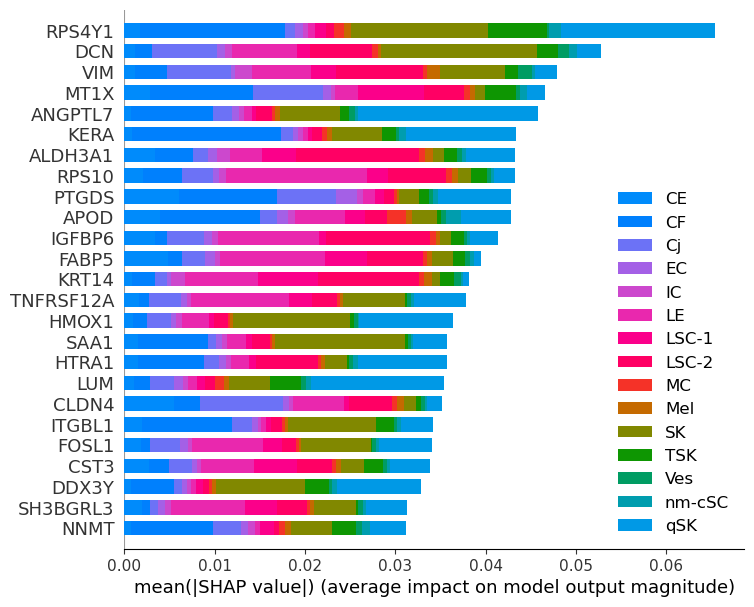

In [31]:
shap.summary_plot(shap_values, data_test3, class_inds="original", class_names=cls.classes_,max_display=25, plot_size=(8, 7))

In [32]:
df_category_colors = pd.read_csv("/mnt/c/Users/jarts/Documents/cpred_model/ipsc/colord_cor.tsv", header=None,index_col=False, sep='\t') #_cor
df_category_colors.columns = ['Category', 'Color']
category_colors = dict(zip(df_category_colors['Category'], df_category_colors['Color']))
category_colors

{'CE': '#1874CD',
 'CF': '#CD6600',
 'Cj': '#191970',
 'EC': '#87CEFA',
 'IC': '#00CED1',
 'LE': '#66CDAA',
 'LSC-1': '#66CD00',
 'LSC-2': '#76EE00',
 'MC': '#CD3700',
 'Mel': '#FFFF00',
 'SK': '#EEAD0E',
 'TSK': '#FF7F00',
 'Ves': '#8B2323',
 'nm-cSC': '#FF0000',
 'qSK': '#FFB90F'}

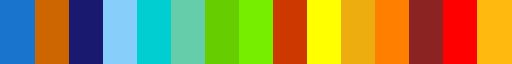

In [33]:
from matplotlib import colors as plt_colors
cmap2 = plt_colors.ListedColormap(df_category_colors['Color']) #df_category_colors['Color']
cmap2

In [34]:
cls.classes_

array(['CE', 'CF', 'Cj', 'EC', 'IC', 'LE', 'LSC-1', 'LSC-2', 'MC', 'Mel',
       'SK', 'TSK', 'Ves', 'nm-cSC', 'qSK'], dtype=object)

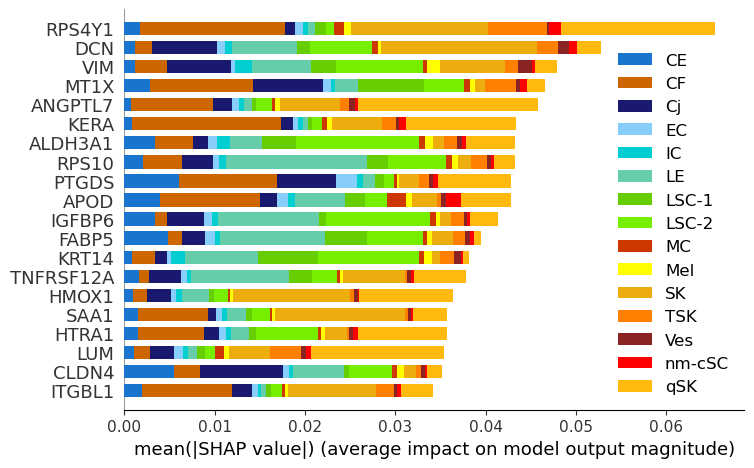

In [38]:
shap.summary_plot(shap_values, data_test3, class_inds="original", class_names=cls.classes_,color=cmap2,max_display=20, plot_size=(8, 5.2))

In [39]:
# Top 50 features for each cell state
import numpy as np
list_states = cls.classes_
for count, value in enumerate(list_states):
    shap_sel = [shap_values[count]]
    vals= np.abs(shap_sel).mean(0)

    feature_importance = pd.DataFrame(list(zip(data_test3.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
    feature_importance.head(50)

    top_shap = feature_importance.head(50)
    top_shap

    top_shap.to_csv(f'/mnt/c/Users/jarts/Documents/cpred_model/adultmaiti/{type}/{value}_shap_50.csv', sep='\t', index=False, header=True)

In [40]:
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(data_test3.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(400)

top_shap = feature_importance.head(400)
top_shap

top_shap.to_csv(f'/mnt/c/Users/jarts/Documents/cpred_model/adultmaiti/{type}/all_shap_400.csv', sep='\t', index=False, header=True)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


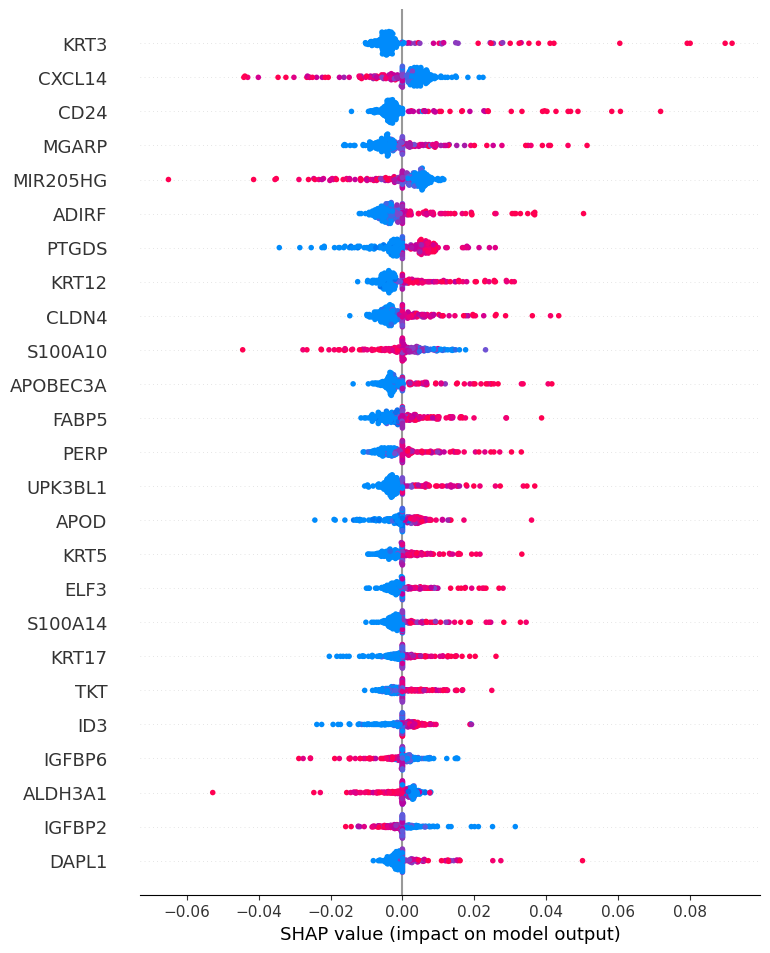

In [41]:
# CE
shap.summary_plot(shap_values[0], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


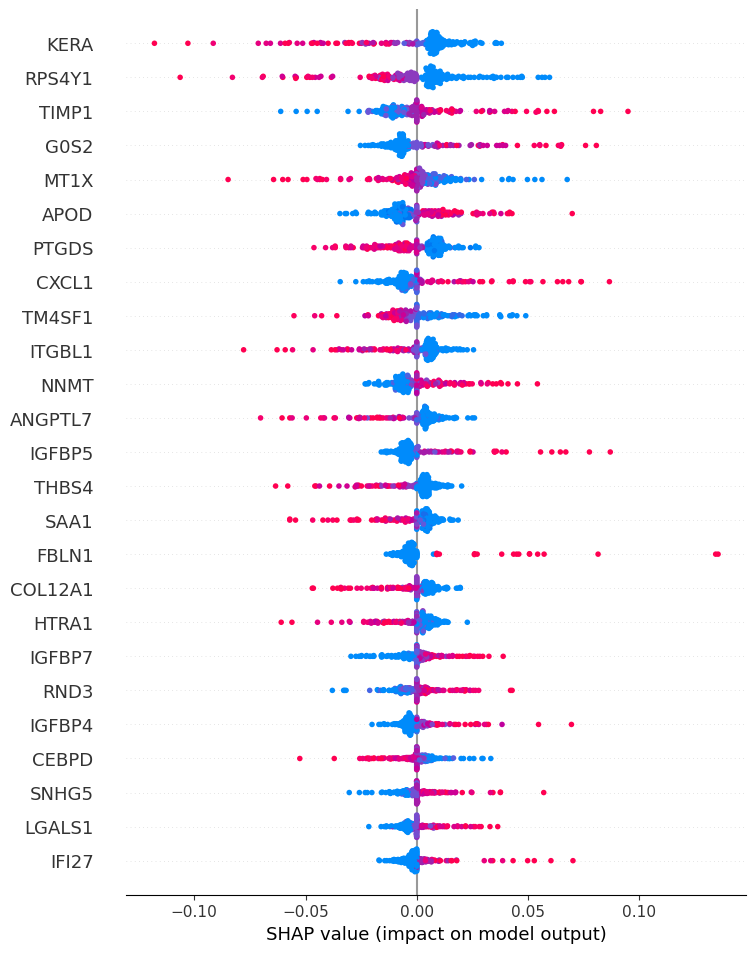

In [42]:
#CF
shap.summary_plot(shap_values[1], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


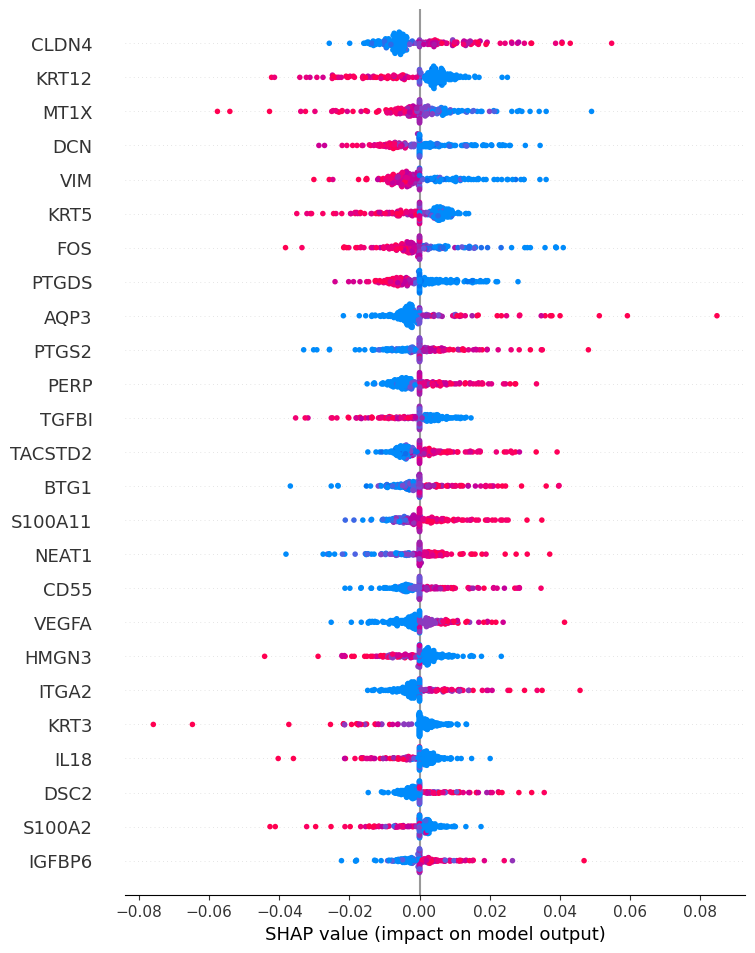

In [43]:
# Cj
shap.summary_plot(shap_values[2], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


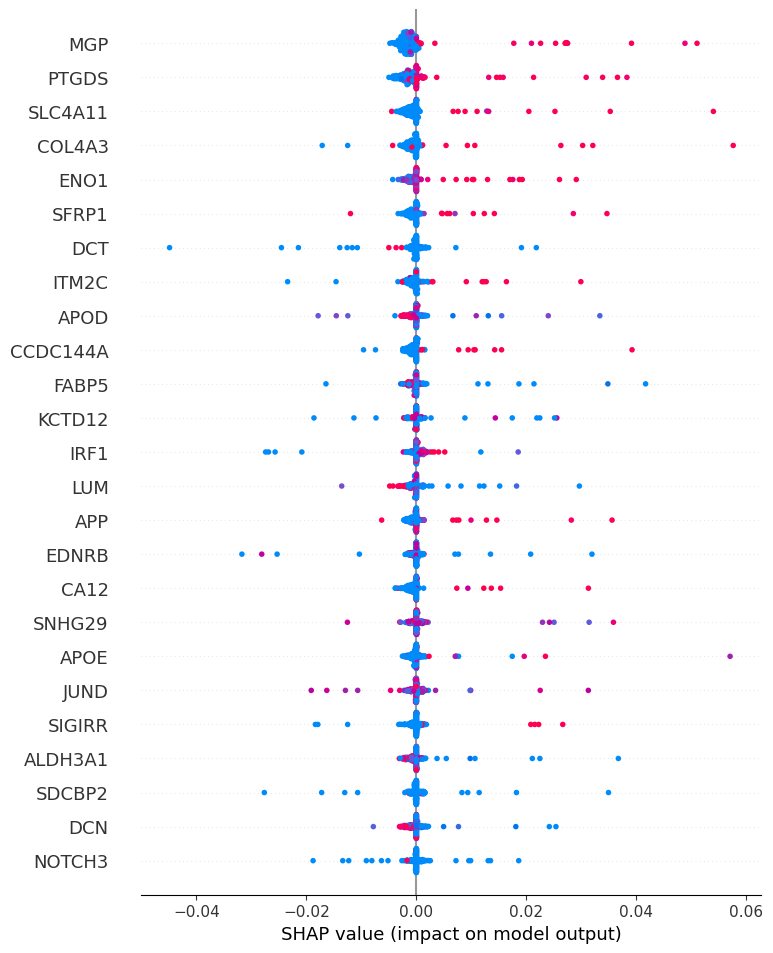

In [44]:
# EC
shap.summary_plot(shap_values[3], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


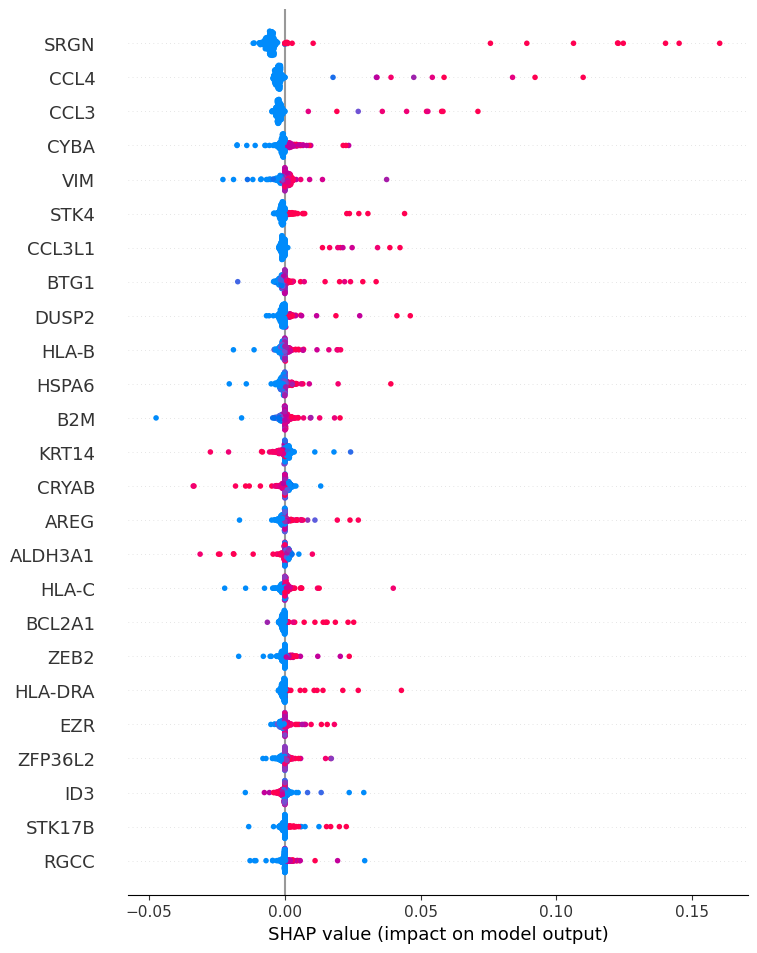

In [45]:
# IC
shap.summary_plot(shap_values[4], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


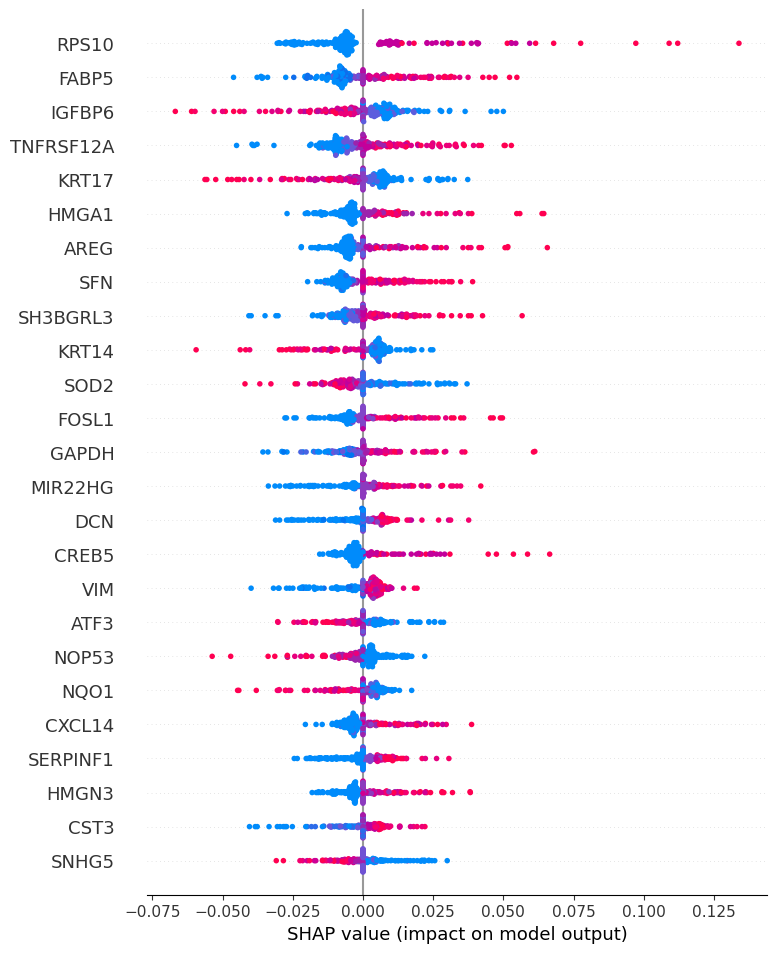

In [46]:
# LE
shap.summary_plot(shap_values[5], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


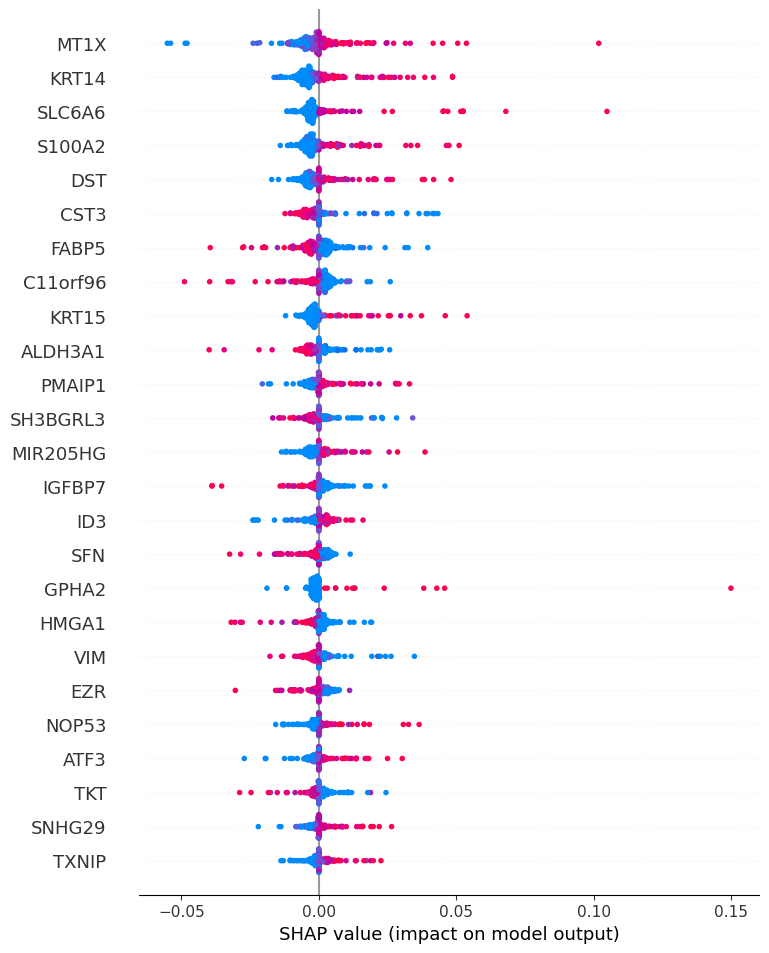

In [47]:
# LSC-1
shap.summary_plot(shap_values[6], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


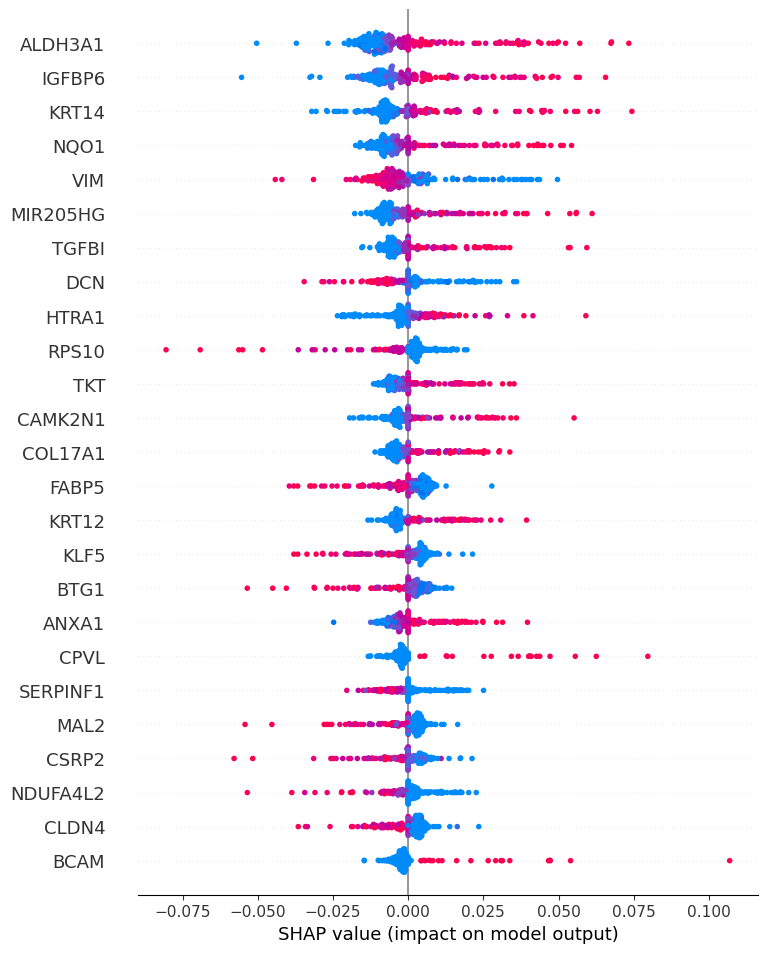

In [48]:
# LSC-2
shap.summary_plot(shap_values[7], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


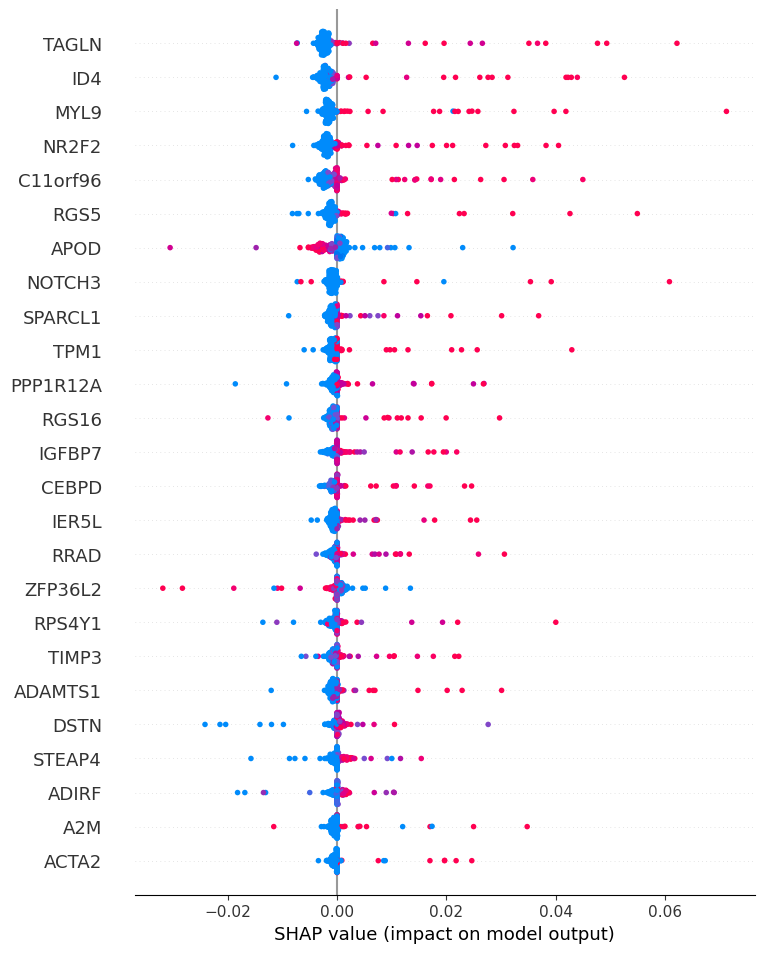

In [49]:
# MC
shap.summary_plot(shap_values[8], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


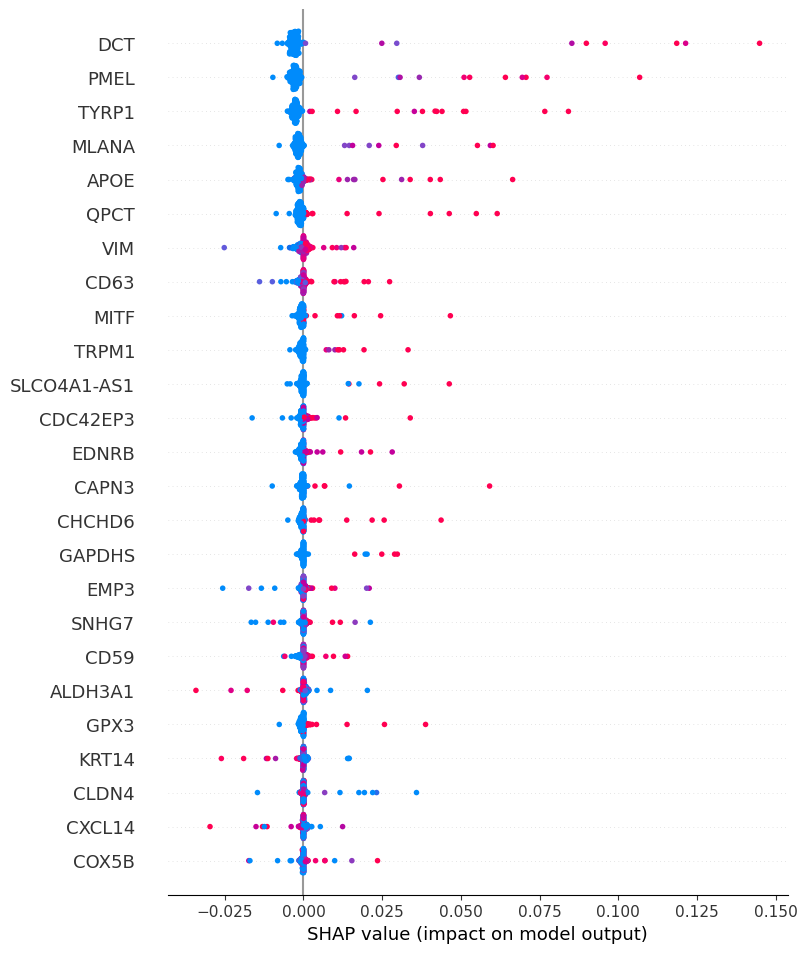

In [50]:
# Mel
shap.summary_plot(shap_values[9], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


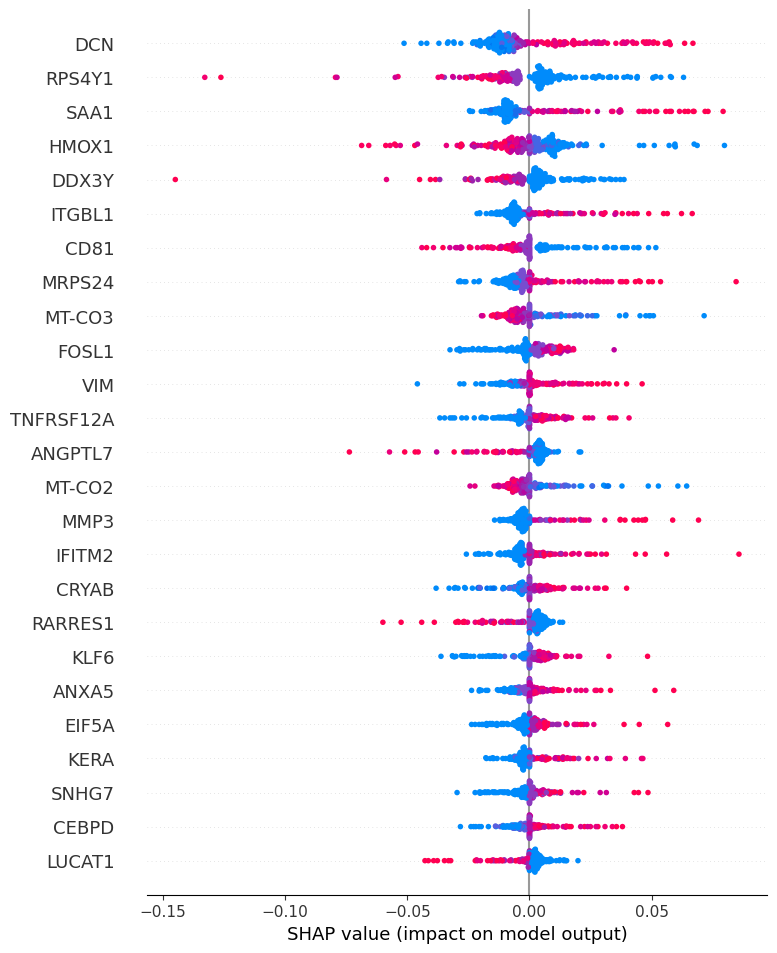

In [51]:
# SK
shap.summary_plot(shap_values[10], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


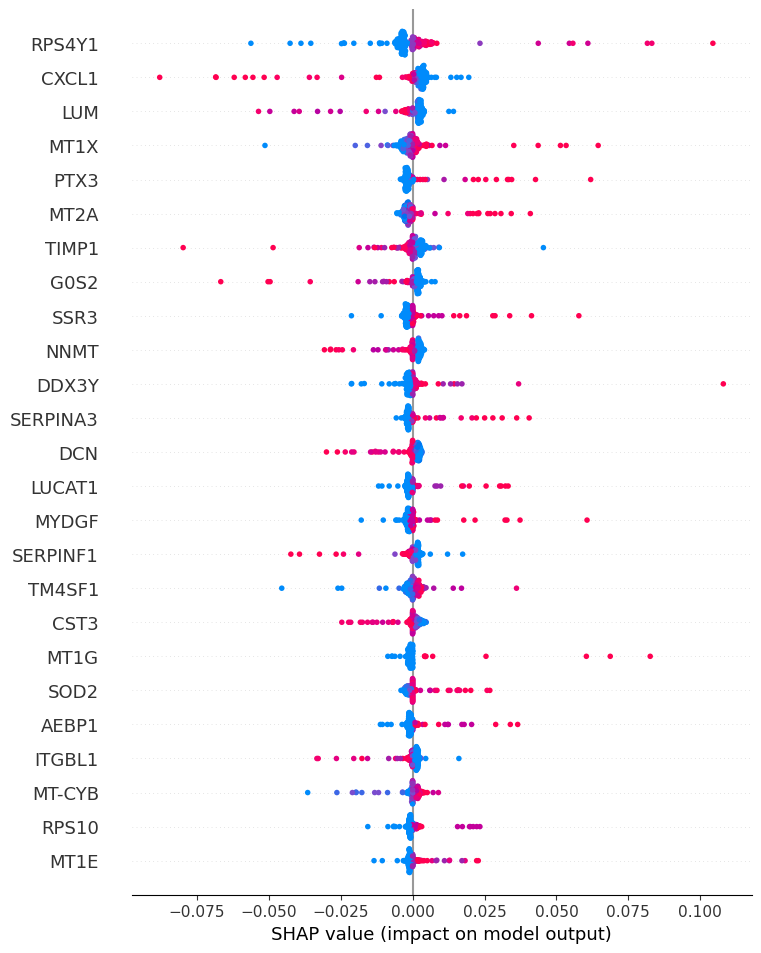

In [52]:
# TSK
shap.summary_plot(shap_values[11], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


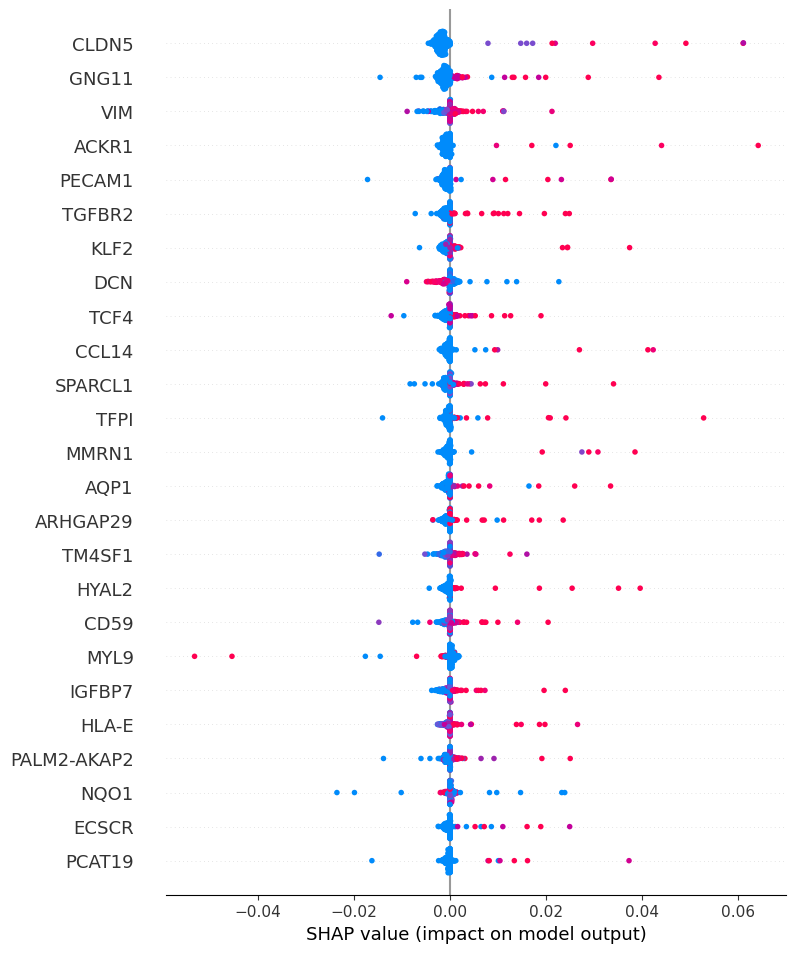

In [53]:
# Ves
shap.summary_plot(shap_values[12], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


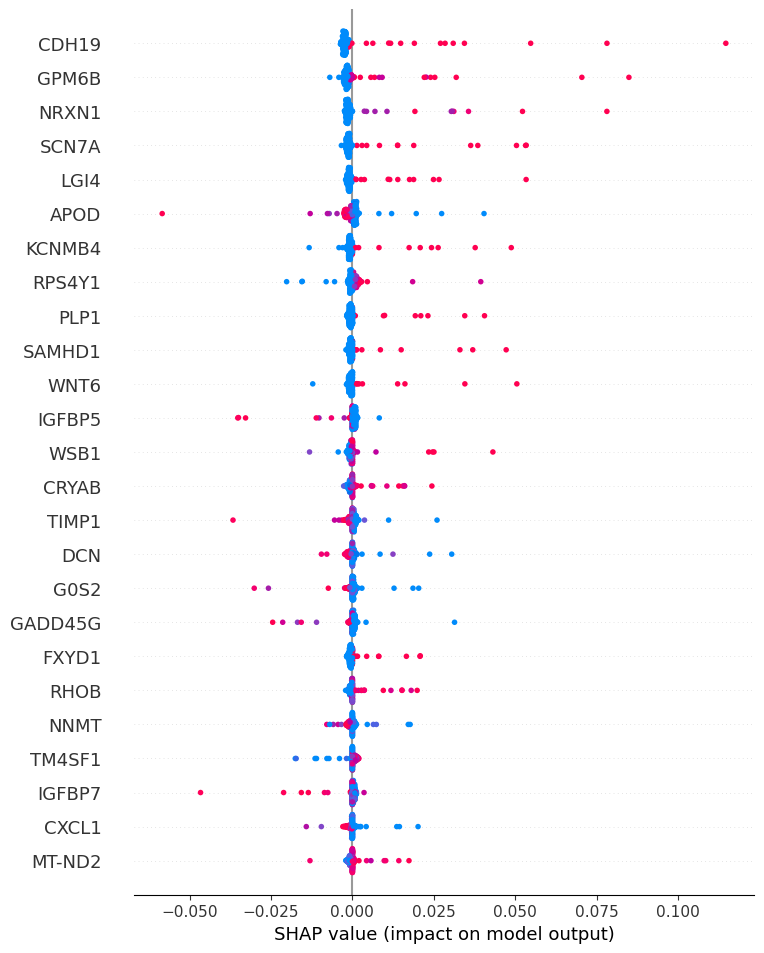

In [54]:
# nm-cSC
shap.summary_plot(shap_values[13], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


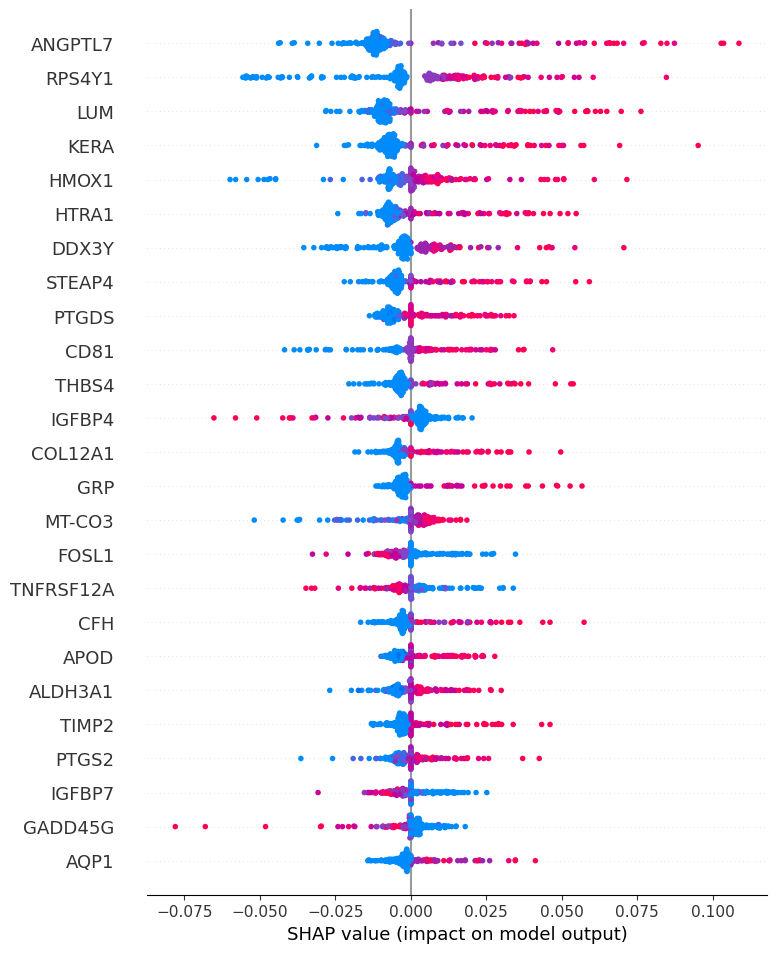

In [57]:
# qSK
shap.summary_plot(shap_values[14], data_test3, feature_names = data_test.columns,color_bar=False,max_display=25)